# Install dependency

In [ ]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


# Mount Cloud for the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls "/content/gdrive/MyDrive/Dataset-yahoo-answer"

classes.txt  lda  readme.txt  test.csv	top2vec  train.csv


# Install Java


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


# Download Mallet


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-04-08 19:27:41--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.2’

mallet-2.0.8.zip.2  100%[===================>]  15.43M  17.7MB/s    in 0.9s    

2021-04-08 19:27:42 (17.7 MB/s) - ‘mallet-2.0.8.zip.2’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Initialization

In [ ]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
from gensim import corpora
from gensim.models.wrappers.ldamallet import LdaMallet, malletmodel2ldamodel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import seaborn as sns
from matplotlib import pyplot as plt
import re
import plotly.express as px
# import pyLDAvis
# import pyLDAvis.gensim
from gensim.test.utils import datapath
from wordcloud import WordCloud
import numpy as np
import pickle
import warnings

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
NUM_ITERATIONS = 2000
MAX_K = 40
RANDOM_SEED = 42
MIN_TOKEN = 5

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(RANDOM_SEED)
rcParams['figure.figsize'] = 12,8

PATH = '/content/gdrive/MyDrive/Dataset-yahoo-answer/'

# Set Mallet Path

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

#Read Data

In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Dataset-yahoo-answer/test.csv', header=None ,names=['topic', 'title', 'question', 'answer'])

In [ ]:
df_train.tail(10)

,topic,title,question,answer
59990,1,Is Adam in heaven or hell for commiting origin...,NaN,First Adam may not even be a real name but a r...
59991,10,Why do the conservatives want us to stay and p...,Cant they see we will just keep losing troops....,George Bush illegally and unconstitutionally i...
59992,6,Who else thinks that ref(uru) should be reprim...,"Can you believe that guy???? Red card, red car...",What about the obvious handball? The ref shou...
59993,10,first black president of the united states?,NaN,"Gerald,\n\nThat's easy. You!"
59994,9,guys only pleez?,is their anyone out their 4 me who are 13to15 ...,omg i love that in a girrl\nim not looking for...
59995,9,"if you could be any fantasy figure, who would ...",NaN,"The invisible man, I'd be straight into the gi..."
59996,8,Tell me something about life most people don't...,"Do you know anything about life, or words of w...",That there is a hell and everyone thinks their...
59997,3,Why are men always thinking of sex?,NaN,It's wired in our brain
59998,6,est ce que DOMENECH est un entraineur: 1: de f...,NaN,de foot mais pas pour être sélectionneur d'une...
59999,5,No sound or low sound?,I have my volume turned up all the way and hav...,"As an old techie, I tend to look at the hardwa..."


In [ ]:
df_train.shape

(60000, 4)

In [ ]:
df_train.to_csv('new.csv')

# Check Distribution

Text(0.5, 1.0, 'Number of instances per topic')

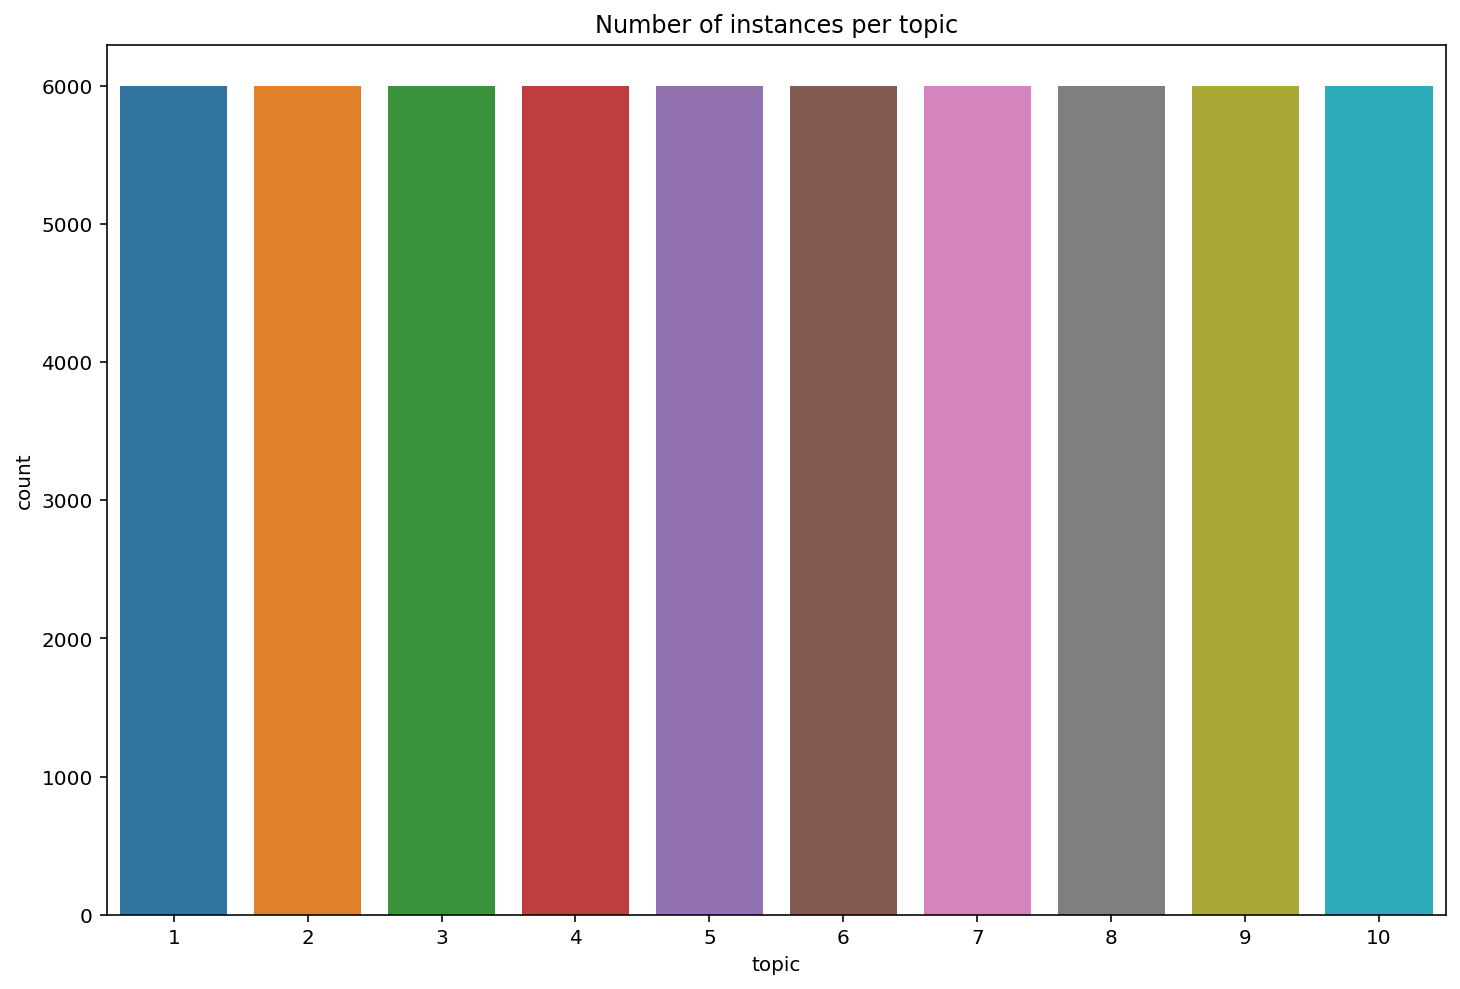

In [ ]:
chart = sns.countplot(df_train.topic)
plt.title("Number of instances per topic")

# Preprocess

In [ ]:
def preprocess_tokenize(s):
    '''
    This function takes a string as an input and then preprocess the string.
    The preprocessing involves  
        1. removing html tags
        2. removing hyperlinks 
        3. removing \n
        4. making all letters lower-case
        5. removing all punctuations, special characters and digits
        6. tokenization 
        7. lemmatization
    Inputs:
        s: s is a string
    returns:
        tokenized version of input s. s is a list
    '''
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    
    cleanr = re.compile('<.*?>')
    s = re.sub(cleanr, '', s)      #removing html tags         
    s = re.sub(r"http\S+", "", s)  #removing hyper link
    s = re.sub(r"www\S+", "", s)   #removing hyper link
    s = re.sub(r"\\n", "", s)      #removing \n 
    s = s.lower()  
    s = tokenizer.tokenize(s)   #tokenizing sentence
    
    processed_string = []
    for word in s:
        if word not in stop_words:                  #removing stopwords
            word = lemmatizer.lemmatize(word, 'v')  #converting a word to verb
            word = lemmatizer.lemmatize(word, 'n')  #converting a word to noun
            word = lemmatizer.lemmatize(word, 'a')  #converting a word to adjective

            processed_string.append(word)
            
    return processed_string
            

In [ ]:
df_train['processed_answer'] = df_train.answer.apply(lambda x: preprocess_tokenize(str(x)))

In [ ]:
df_train.head()

,topic,title,question,answer,processed_answer
0,9,What makes friendship click?,How does the spark keep going?,good communication is what does it. Can you m...,"[good, communication, move, beyond, small, tal..."
1,2,Why does Zebras have stripes?,What is the purpose or those stripes? Who do t...,this provides camouflage - predator vision is ...,"[provide, camouflage, predator, vision, usuall..."
2,4,What did the itsy bitsy sipder climb up?,NaN,waterspout,[waterspout]
3,4,What is the difference between a Bachelors and...,NaN,One difference between a Bachelors and a Maste...,"[one, difference, bachelor, master, degree, re..."
4,3,Why do women get PMS?,NaN,Premenstrual syndrome (PMS) is a group of symp...,"[premenstrual, syndrome, pm, group, symptom, r..."


In [ ]:
df_train['processed_answer'].apply(len)

0        20
1         9
2         1
3        76
4        45
         ..
59995     6
59996    13
59997     2
59998    22
59999    55
Name: processed_answer, Length: 60000, dtype: int64

(array([5.8056e+04, 1.4120e+03, 5.2000e+02, 1.0000e+01, 2.0000e+00]),
 array([  0. , 136.8, 273.6, 410.4, 547.2, 684. ]),
 <a list of 5 Patch objects>)

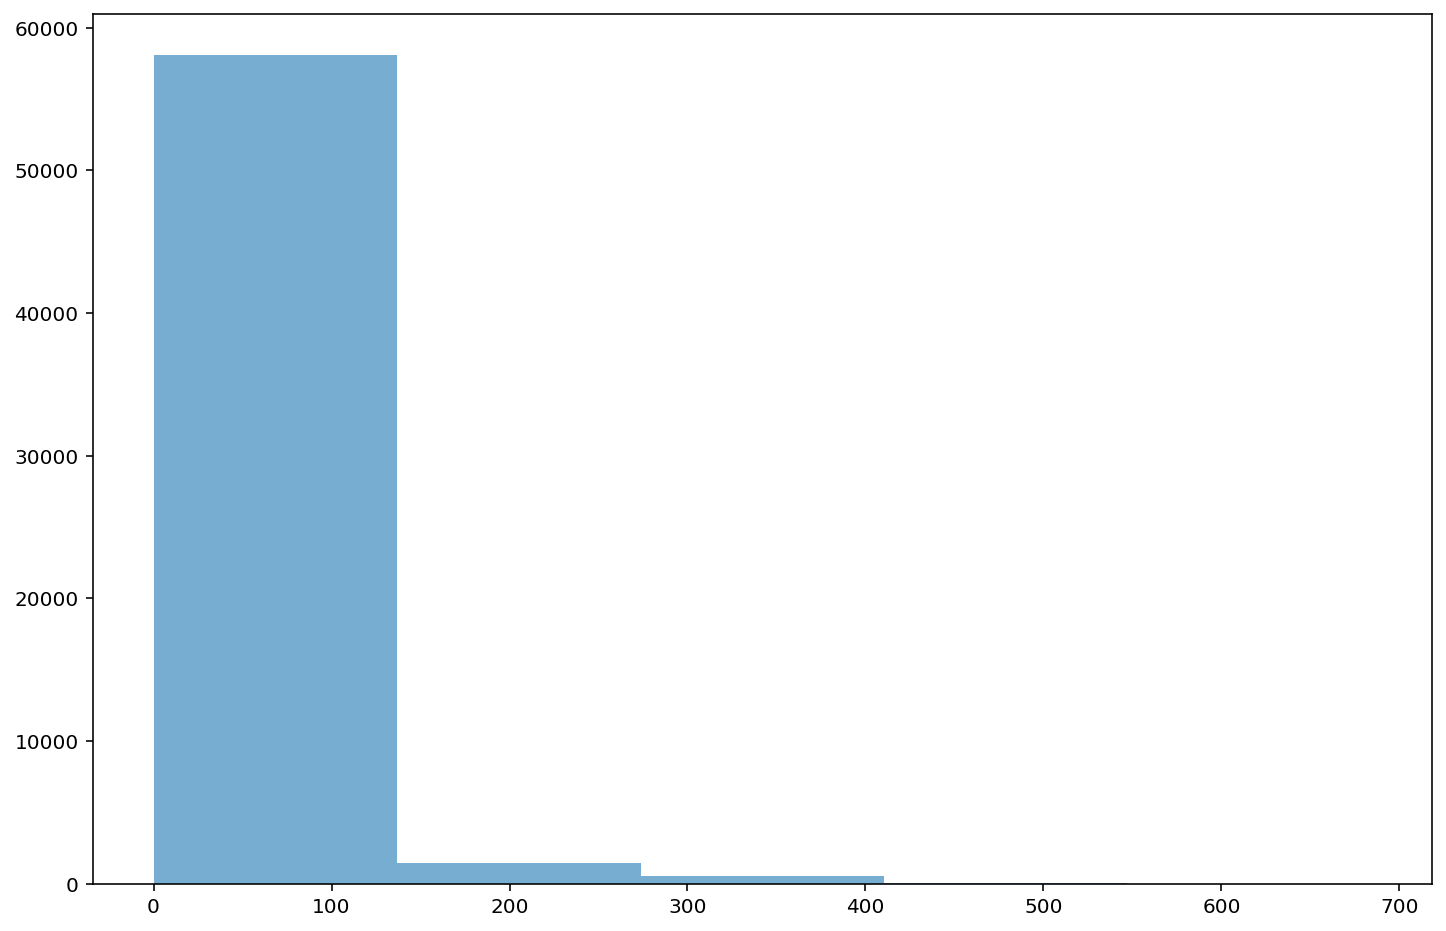

In [ ]:
df_train['processed_length'] = df_train['processed_answer'].apply(len)
bins = 5
plt.hist(df_train['processed_length'], alpha = 0.6, bins=bins)

In [ ]:
# corpus will have documents with at least 5 tokens 
processed_texts = df_train[df_train['processed_length']>MIN_TOKEN].processed_answer

In [ ]:
df_processed_data = df_train[df_train['processed_length']>MIN_TOKEN]

# Create corpus

In [ ]:
def create_bow(dictionary, texts):
    '''
    This function takes two inputs a dictionary and a list of tokenized documents 
    and creates a corpus. Each lists in the corpus represents a document where
    each tuple inside a list is the id of the word in the document and its count.
    
    Inputs:
        dictionary: a gensim dictionary where the key is the word and value is the 
        corresponding id
        
        texts: a list of documents where each document is tokenized
    
    returns:
        corpus
    '''
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus
    

In [ ]:
def create_dictionary_corpus(texts):
    '''
    This function takes a list of tokenized documents as inputs and 
    return a dictionary and corpus.
    
    Inputs:
        texts: a list of tokenized documents
        
    returns:
        dictionary: a gensim dictionary where the key is the id and value is the 
        corresponding word
        
        corpus: gensim corpus
    '''
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = create_bow(dictionary, texts)
    return dictionary, corpus

In [ ]:
dictionary, corpus = create_dictionary_corpus(processed_texts)

# Model generation

In [ ]:
def find_best_lda_model(max_k, corpus, dictionary, texts):
    '''
    This function takes four parameters as inputs and find best lda model
    
    Inputs:
        max_k: an interger which indicates maximum number of topics to evaluate. 
        max_k should be >=10. The function starts with 10 topics and the increment is 10. 
        For example, If max_k = 30, it will calculate best_ k for 10, 20, and 30 topics
        
        corpus: gensim corpus
        
        dictionary: gensim dictionary of texts
        
        texts: a list of tokenized documents
        
    returns:
        best_lda_model: best mallet lda model based on coherence score
        
        best_k: an integer of number of topics for best lda model
        
        all_k: a list of all the values of number of topics that is used to find the best_k
        
    '''
    
    all_k = []
    coherence_scores = []
    best_lda_model = ''
    best_coherence = -1
    best_k = 0
    
    for k in range(10, max_k+1, 10):
        # running lda model for a specific k
        lda_model = LdaMallet(mallet_path, corpus = corpus, id2word= dictionary, 
                        num_topics = k, iterations = NUM_ITERATIONS,  random_seed=RANDOM_SEED)
        
        #getting coherence score  for lda_model
        coherence_model = CoherenceModel(model = lda_model, corpus = corpus, 
                                 coherence = 'c_v', texts = texts, dictionary = dictionary)
        coherence_score = coherence_model.get_coherence()
        
        
        #saving best model
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_lda_model = lda_model
            best_k = k
            
        coherence_scores.append(coherence_score)
        all_k.append(k)
    
    return best_lda_model, best_k, all_k, coherence_scores

In [ ]:
def plot_topic_coherence(all_k, coherences):
    '''
    Given all topics and corresponding coherence scores, this function
    plots topic vs coherence score plot
    
    Inputs:
        all_k: a list of topic number the cohernce score is calculated for
        
        coherences: a list of coherence scores of corresponding topic numbers. The
        len should be equal to all_k
    
    Returns: None  
    
    Display:
        topic vs coherence plot
    '''
    
    df = pd.DataFrame({
        'k': all_k,
        'coherence': coherences
    })
    
    fig = px.line(df, x= 'k', y= 'coherence')
    # fig.write_html('./lda/topicsvscoherence.html')
    fig.show()

In [ ]:
mallet_lda_model, best_k, all_k, coherence_scores = find_best_lda_model(MAX_K,  corpus, dictionary, processed_texts)

In [ ]:
plot_topic_coherence(all_k, coherence_scores)

### The best model we can get for k=20 according to topic-coherence.

# Save model and data files

In [ ]:
mallet_lda_model = LdaMallet(mallet_path, corpus = corpus, id2word= dictionary, 
                        num_topics = best_k, iterations = NUM_ITERATIONS, prefix = PATH+'/lda/', random_seed=RANDOM_SEED)

In [ ]:
with open(PATH+'/lda/saved/mallet_lda.model', 'wb') as file:
    pickle.dump(mallet_lda_model, file)

In [ ]:
gensimmodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_lda_model)

In [ ]:
with open(PATH+'/lda/saved/gensim.model', 'wb') as file:
    pickle.dump(gensimmodel, file)

In [ ]:
with open(PATH+'/lda/saved/courpus.corp', 'wb') as file:
    pickle.dump(corpus, file)

In [ ]:
with open(PATH+'/lda/saved/dictionary.dict', 'wb') as file:
    pickle.dump(dictionary, file)

In [ ]:
with open(PATH+'/lda/saved/data.pkl', 'wb') as file:
    pickle.dump(df_processed_data, file)